### Import

In [152]:
import sys
from random import random
from operator import add
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, hour, avg, unix_timestamp, sum as spark_sum
import matplotlib.pyplot as plt
import pandas as pd

In [149]:
pip install openmeteo-requests


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


25/07/29 09:57:28 WARN TaskSetManager: Lost task 0.3 in stage 8.0 (TID 133) (172.18.0.3 executor 0): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 2044, in main
    process()
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 2034, in process
    out_iter = func(split_index, iterator)
  File "/usr/local/lib/python3.10/site-packages/pyspark/core/rdd.py", line 5306, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/lib/python3.10/site-packages/pyspark/core/rdd.py", line 5306, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/lib/python3.10/site-packages/pyspark/core/rdd.py", line 705, in func
    return f(iterator)
  File "/tmp/ipykernel_177/3552365638.py", line 2, in fetch_weather_partition
ModuleNotFoundError: No module named 'openmeteo_requests'

	at org.apache.spark.api.python.BasePythonRunner$Re

In [150]:
pip install requests-cache retry-requests numpy tqdm pandas matplotlib


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Spark Session

In [153]:
spark = SparkSession \
    .builder \
    .appName("PythonPi") \
    .master("spark://master:7077") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

if len(sys.argv) > 1 and sys.argv[1].isdigit():
    partitions = int(sys.argv[1])
else:
    partitions = 2

### Extract Data

In [154]:
df = spark.read.parquet("/opt/spark-data/tlc_trip_record_data/", header=True, inferSchema=True)
selected_df = df.select("VendorID", "tpep_pickup_datetime", "tpep_dropoff_datetime", "trip_distance", "PULocationID", "DOLocationID")

[Stage 6:====>                                                     (7 + 1) / 99]

In [105]:
selected_df.show()

+--------+--------------------+---------------------+-------------+------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|PULocationID|DOLocationID|
+--------+--------------------+---------------------+-------------+------------+------------+
|       1| 2015-10-01 00:04:43|  2015-10-01 00:10:17|          1.6|          25|          49|
|       1| 2015-10-01 00:13:58|  2015-10-01 00:51:32|         10.2|          97|         143|
|       1| 2015-10-01 00:53:57|  2015-10-01 00:57:18|          1.4|         239|          24|
|       1| 2015-10-01 00:59:04|  2015-10-01 01:00:07|          0.4|          24|         166|
|       1| 2015-10-01 00:01:45|  2015-10-01 00:09:36|          2.0|          43|         238|
|       1| 2015-10-01 00:14:55|  2015-10-01 00:19:55|          0.7|          24|          41|
|       1| 2015-10-01 00:43:11|  2015-10-01 00:53:12|          2.8|         162|         238|
|       1| 2015-10-01 00:10:30|  2015-10-01 00:12:42|       

In [107]:
selected_df.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)



In [108]:
selected_df.count()

776914022

### Transform Data

In [155]:
# null 값이 존재하는 row 확인
null_counts = selected_df.select([
    spark_sum(col(c).isNull().cast("int")).alias(c + "_nulls") for c in selected_df.columns
])

null_counts.show()

25/07/30 00:59:26 ERROR TaskSchedulerImpl: Lost executor 20 on 172.18.0.2: Command exited with code 137
25/07/30 00:59:26 WARN TaskSetManager: Lost task 20.0 in stage 11.0 (TID 159) (172.18.0.2 executor 20): ExecutorLostFailure (executor 20 exited caused by one of the running tasks) Reason: Command exited with code 137
25/07/30 00:59:26 WARN TaskSetManager: Lost task 22.0 in stage 11.0 (TID 161) (172.18.0.2 executor 20): ExecutorLostFailure (executor 20 exited caused by one of the running tasks) Reason: Command exited with code 137
25/07/30 00:59:26 WARN TaskSetManager: Lost task 23.0 in stage 11.0 (TID 162) (172.18.0.2 executor 20): ExecutorLostFailure (executor 20 exited caused by one of the running tasks) Reason: Command exited with code 137
25/07/30 00:59:26 WARN TaskSetManager: Lost task 26.0 in stage 11.0 (TID 165) (172.18.0.2 executor 20): ExecutorLostFailure (executor 20 exited caused by one of the running tasks) Reason: Command exited with code 137
25/07/30 00:59:26 WARN TaskS

+--------------+--------------------------+---------------------------+-------------------+------------------+------------------+
|VendorID_nulls|tpep_pickup_datetime_nulls|tpep_dropoff_datetime_nulls|trip_distance_nulls|PULocationID_nulls|DOLocationID_nulls|
+--------------+--------------------------+---------------------------+-------------------+------------------+------------------+
|             0|                         0|                          0|                  0|                 0|                 0|
+--------------+--------------------------+---------------------------+-------------------+------------------+------------------+



[Stage 6:====>                                                     (7 + 1) / 99]

In [156]:
# pickup < dropoff인 것만 남기기
selected_df = selected_df.filter(col("tpep_pickup_datetime") < col("tpep_dropoff_datetime"))

# trip_distance > 0인 것만 남기기
selected_df = selected_df.filter(col("trip_distance") > 0)

In [157]:
selected_df = selected_df.withColumn(
    "trip_duration_sec", 
    (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime"))
)
selected_df = selected_df.withColumn("pickup_hour", hour("tpep_pickup_datetime"))

### Data Analytics

#### Average Distance & Duration

In [158]:
# 평균 거리와 평균 기간 계산
averages = selected_df.select(
    avg("trip_duration_sec").alias("avg_duration_sec"),
    avg("trip_distance").alias("avg_trip_distance")
).collect()[0]

[Stage 6:====>                                                     (7 + 1) / 99]

In [115]:
summary_df = pd.DataFrame([{
    "avg_duration_min": round(averages['avg_duration_sec'] / 60, 2),
    "avg_trip_distance_miles": round(averages['avg_trip_distance'], 2)
}])

# CSV로 저장
summary_df.to_csv("/opt/spark-data/trip_summary.csv", index=False)

#### Peak Hour

In [116]:
hourly_counts = selected_df.groupBy("pickup_hour").agg(count("*").alias("trip_count"))

# toPandas()로 변환
pdf = hourly_counts.orderBy("pickup_hour").toPandas()

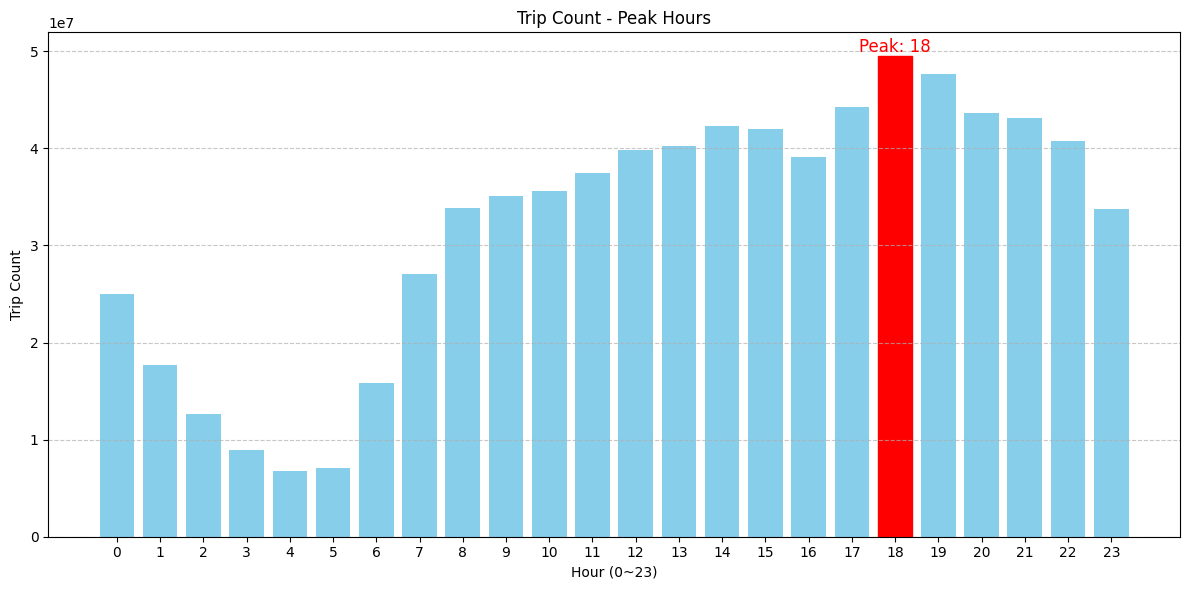

In [117]:
# 피크 시간대 찾기
peak_hour = pdf.loc[pdf['trip_count'].idxmax(), 'pickup_hour']

# 시각화
plt.figure(figsize=(12, 6))
bars = plt.bar(pdf['pickup_hour'], pdf['trip_count'], color='skyblue')

# 피크 시간 강조
bars[peak_hour].set_color('red')
plt.title("Trip Count - Peak Hours")
plt.xlabel("Hour (0~23)")
plt.ylabel("Trip Count")
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 피크 시간 레이블 추가
plt.text(peak_hour, pdf['trip_count'].max(), f'Peak: {peak_hour}', ha='center', va='bottom', fontsize=12, color='red')

plt.tight_layout()
plt.show()

#### Weather

In [160]:
# LocationID + 위도/경도 데이터 불러오기
zone_df = spark.read.parquet("/opt/spark-data/zone_with_coords.parquet")

# join
joined_df = selected_df.join(zone_df, selected_df.PULocationID == zone_df.LocationID, how='left').drop('LocationID', 'Borough', 'Zone', 'service_zone')

[Stage 6:====>                                                     (7 + 1) / 99]

In [165]:
def fetch_weather_data(lat, lon, start="2015-01-01", end="2025-07-30"):
    import openmeteo_requests
    import requests_cache
    from retry_requests import retry
    import pandas as pd

    cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
    retry_session = retry(cache_session, retries=3, backoff_factor=0.2)
    client = openmeteo_requests.Client(session=retry_session)

    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start,
        "end_date": end,
        "hourly": ["temperature_2m", "precipitation", "relative_humidity_2m"],
        "timezone": "America/New_York",
    }

    try:
        responses = client.weather_api(url, params=params)
        response = responses[0]
        hourly = response.Hourly()
        times = hourly.Time()
        df = pd.DataFrame({
            "datetime": pd.to_datetime(times),
            "latitude": lat,
            "longitude": lon,
            "temperature_2m": hourly.Variables(0).ValuesAsNumpy(),
            "precipitation": hourly.Variables(1).ValuesAsNumpy(),
            "relative_humidity_2m": hourly.Variables(2).ValuesAsNumpy(),
        })
        return spark.createDataFrame(df)
    except Exception:
        print(f"날씨 추출 실패 : {e}")
        raise
print(fetch_weather_data(40.7128, -74.0060))

NameError: name 'e' is not defined

- 보완 필요 (날씨 데이터 수집)

In [162]:
def fetch_weather_partition(rows):
    import openmeteo_requests
    import requests_cache
    from retry_requests import retry

    cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
    retry_session = retry(cache_session, retries=3, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    results = []
    for row in rows:
        hour = row.pickup_hour
        date = row.tpep_pickup_datetime
        lat = row.latitude
        lon = row.longitude

        url = "https://archive-api.open-meteo.com/v1/archive"
        params = {
            "latitude": lat,
            "longitude": lon,
            "start_date": date.strftime("%Y-%m-%d"),
            "end_date": date.strftime("%Y-%m-%d"),
            "hourly": ["temperature_2m", "precipitation", "relative_humidity_2m"],
            "timezone": "America/New_York",
        }

        try:
            responses = openmeteo.weather_api(url, params=params)
            response = responses[0]

            hourly = response.Hourly()
            temp_arr = hourly.Variables(0).ValuesAsNumpy()
            prec_arr = hourly.Variables(1).ValuesAsNumpy()
            hum_arr = hourly.Variables(2).ValuesAsNumpy()

            results.append({
                "pickup_hour": hour,
                "tpep_pickup_datetime": date,
                "latitude": lat,
                "longitude": lon,
                "temperature_2m": float(temp_arr[hour]),
                "precipitation": float(prec_arr[hour]),
                "relative_humidity_2m": float(hum_arr[hour]),
            })
        except Exception as e:
            results.append({
                "pickup_hour": hour,
                "tpep_pickup_datetime": date,
                "latitude": lat,
                "longitude": lon,
                "temperature_2m": None,
                "precipitation": None,
                "relative_humidity_2m": None,
            })
    return iter(results)


# mapPartitions 실행 후 DataFrame 생성
weather_rdd = joined_df.rdd.mapPartitions(fetch_weather_partition)
weather_spark_df = weather_rdd.toDF()

# 조인할 때 key가 동일해야 하니 컬럼명 통일 필요 (예: joined_df에도 동일한 컬럼명)
# 조인 시 'pickup_hour', 'tpep_pickup_datetime', 'latitude', 'longitude' 기준으로 조인
joined_df = joined_df.join(
    weather_spark_df,
    on=["pickup_hour", "tpep_pickup_datetime", "latitude", "longitude"],
    how="left"
)

25/07/30 01:01:05 WARN TaskSetManager: Lost task 0.0 in stage 22.0 (TID 367) (172.18.0.2 executor 21): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 2044, in main
    process()
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 2034, in process
    out_iter = func(split_index, iterator)
  File "/usr/local/lib/python3.10/site-packages/pyspark/core/rdd.py", line 5306, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/lib/python3.10/site-packages/pyspark/core/rdd.py", line 5306, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/lib/python3.10/site-packages/pyspark/core/rdd.py", line 705, in func
    return f(iterator)
  File "/tmp/ipykernel_177/2454134739.py", line 3, in fetch_weather_partition
ModuleNotFoundError: No module named 'requests_cache'

	at org.apache.spark.api.python.BasePythonRunner$Read

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 22.0 failed 4 times, most recent failure: Lost task 0.3 in stage 22.0 (TID 370) (172.18.0.3 executor 19): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 2044, in main
    process()
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 2034, in process
    out_iter = func(split_index, iterator)
  File "/usr/local/lib/python3.10/site-packages/pyspark/core/rdd.py", line 5306, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/lib/python3.10/site-packages/pyspark/core/rdd.py", line 5306, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/lib/python3.10/site-packages/pyspark/core/rdd.py", line 705, in func
    return f(iterator)
  File "/tmp/ipykernel_177/2454134739.py", line 3, in fetch_weather_partition
ModuleNotFoundError: No module named 'requests_cache'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:581)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:940)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:925)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:532)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.mutable.Growable.addAll(Growable.scala:61)
	at scala.collection.mutable.Growable.addAll$(Growable.scala:57)
	at scala.collection.mutable.ArrayBuilder.addAll(ArrayBuilder.scala:75)
	at scala.collection.IterableOnceOps.toArray(IterableOnce.scala:1505)
	at scala.collection.IterableOnceOps.toArray$(IterableOnce.scala:1498)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:189)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2524)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$3(DAGScheduler.scala:2935)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2935)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2927)
	at scala.collection.immutable.List.foreach(List.scala:334)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2927)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1295)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3207)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3141)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3130)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:50)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:1009)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2484)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2505)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2524)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:189)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 2044, in main
    process()
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 2034, in process
    out_iter = func(split_index, iterator)
  File "/usr/local/lib/python3.10/site-packages/pyspark/core/rdd.py", line 5306, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/lib/python3.10/site-packages/pyspark/core/rdd.py", line 5306, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/lib/python3.10/site-packages/pyspark/core/rdd.py", line 705, in func
    return f(iterator)
  File "/tmp/ipykernel_177/2454134739.py", line 3, in fetch_weather_partition
ModuleNotFoundError: No module named 'requests_cache'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:581)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:940)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:925)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:532)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.mutable.Growable.addAll(Growable.scala:61)
	at scala.collection.mutable.Growable.addAll$(Growable.scala:57)
	at scala.collection.mutable.ArrayBuilder.addAll(ArrayBuilder.scala:75)
	at scala.collection.IterableOnceOps.toArray(IterableOnce.scala:1505)
	at scala.collection.IterableOnceOps.toArray$(IterableOnce.scala:1498)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:189)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2524)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more


[Stage 6:====>                                                     (7 + 1) / 99]

In [163]:
spark.stop()